## 第五章 全连接神经网络 分类



In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.manifold import TSNE

In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import hiddenlayer as hl
from torchviz import make_dot

## 垃圾邮件数据分类

| SPAM E-MAIL DATABASE ATTRIBUTES (in .names format)

| 48 continuous real [0,100] attributes of type word_freq_WORD 


| 6 continuous real [0,100] attributes of type char_freq_CHAR

| 1 continuous real [1,...] attribute of type capital_run_length_average
| = average length of uninterrupted sequences of capital letters

| 1 continuous integer [1,...] attribute of type capital_run_length_longest
| = length of longest uninterrupted sequence of capital letters

| 1 continuous integer [1,...] attribute of type capital_run_length_total
| = sum of length of uninterrupted sequences of capital letters
| = total number of capital letters in the e-mail

| 1 nominal {0,1} class attribute of type spam
| = denotes whether the e-mail was considered spam (1) or not (0), 


### 数据准备

In [4]:
## 读取数据显示数据的前几行
spam = pd.read_csv("data/chap5/spambase.csv")
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [5]:
## 计算垃圾邮件和非垃圾邮件的数量
pd.value_counts(spam.label)

## 垃圾邮件有1813个样本，非垃圾邮件有2788个样本

0    2788
1    1813
Name: label, dtype: int64

In [6]:
## 将数据随机切分为训练集和测试集
X = spam.iloc[:,0:57].values   
y = spam.label.values
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25, random_state=123
)

## 对数据的前57列特征进行数据标准化处理
scales = MinMaxScaler(feature_range=(0, 1))
X_train_s = scales.fit_transform(X_train)
X_test_s = scales.transform(X_test)


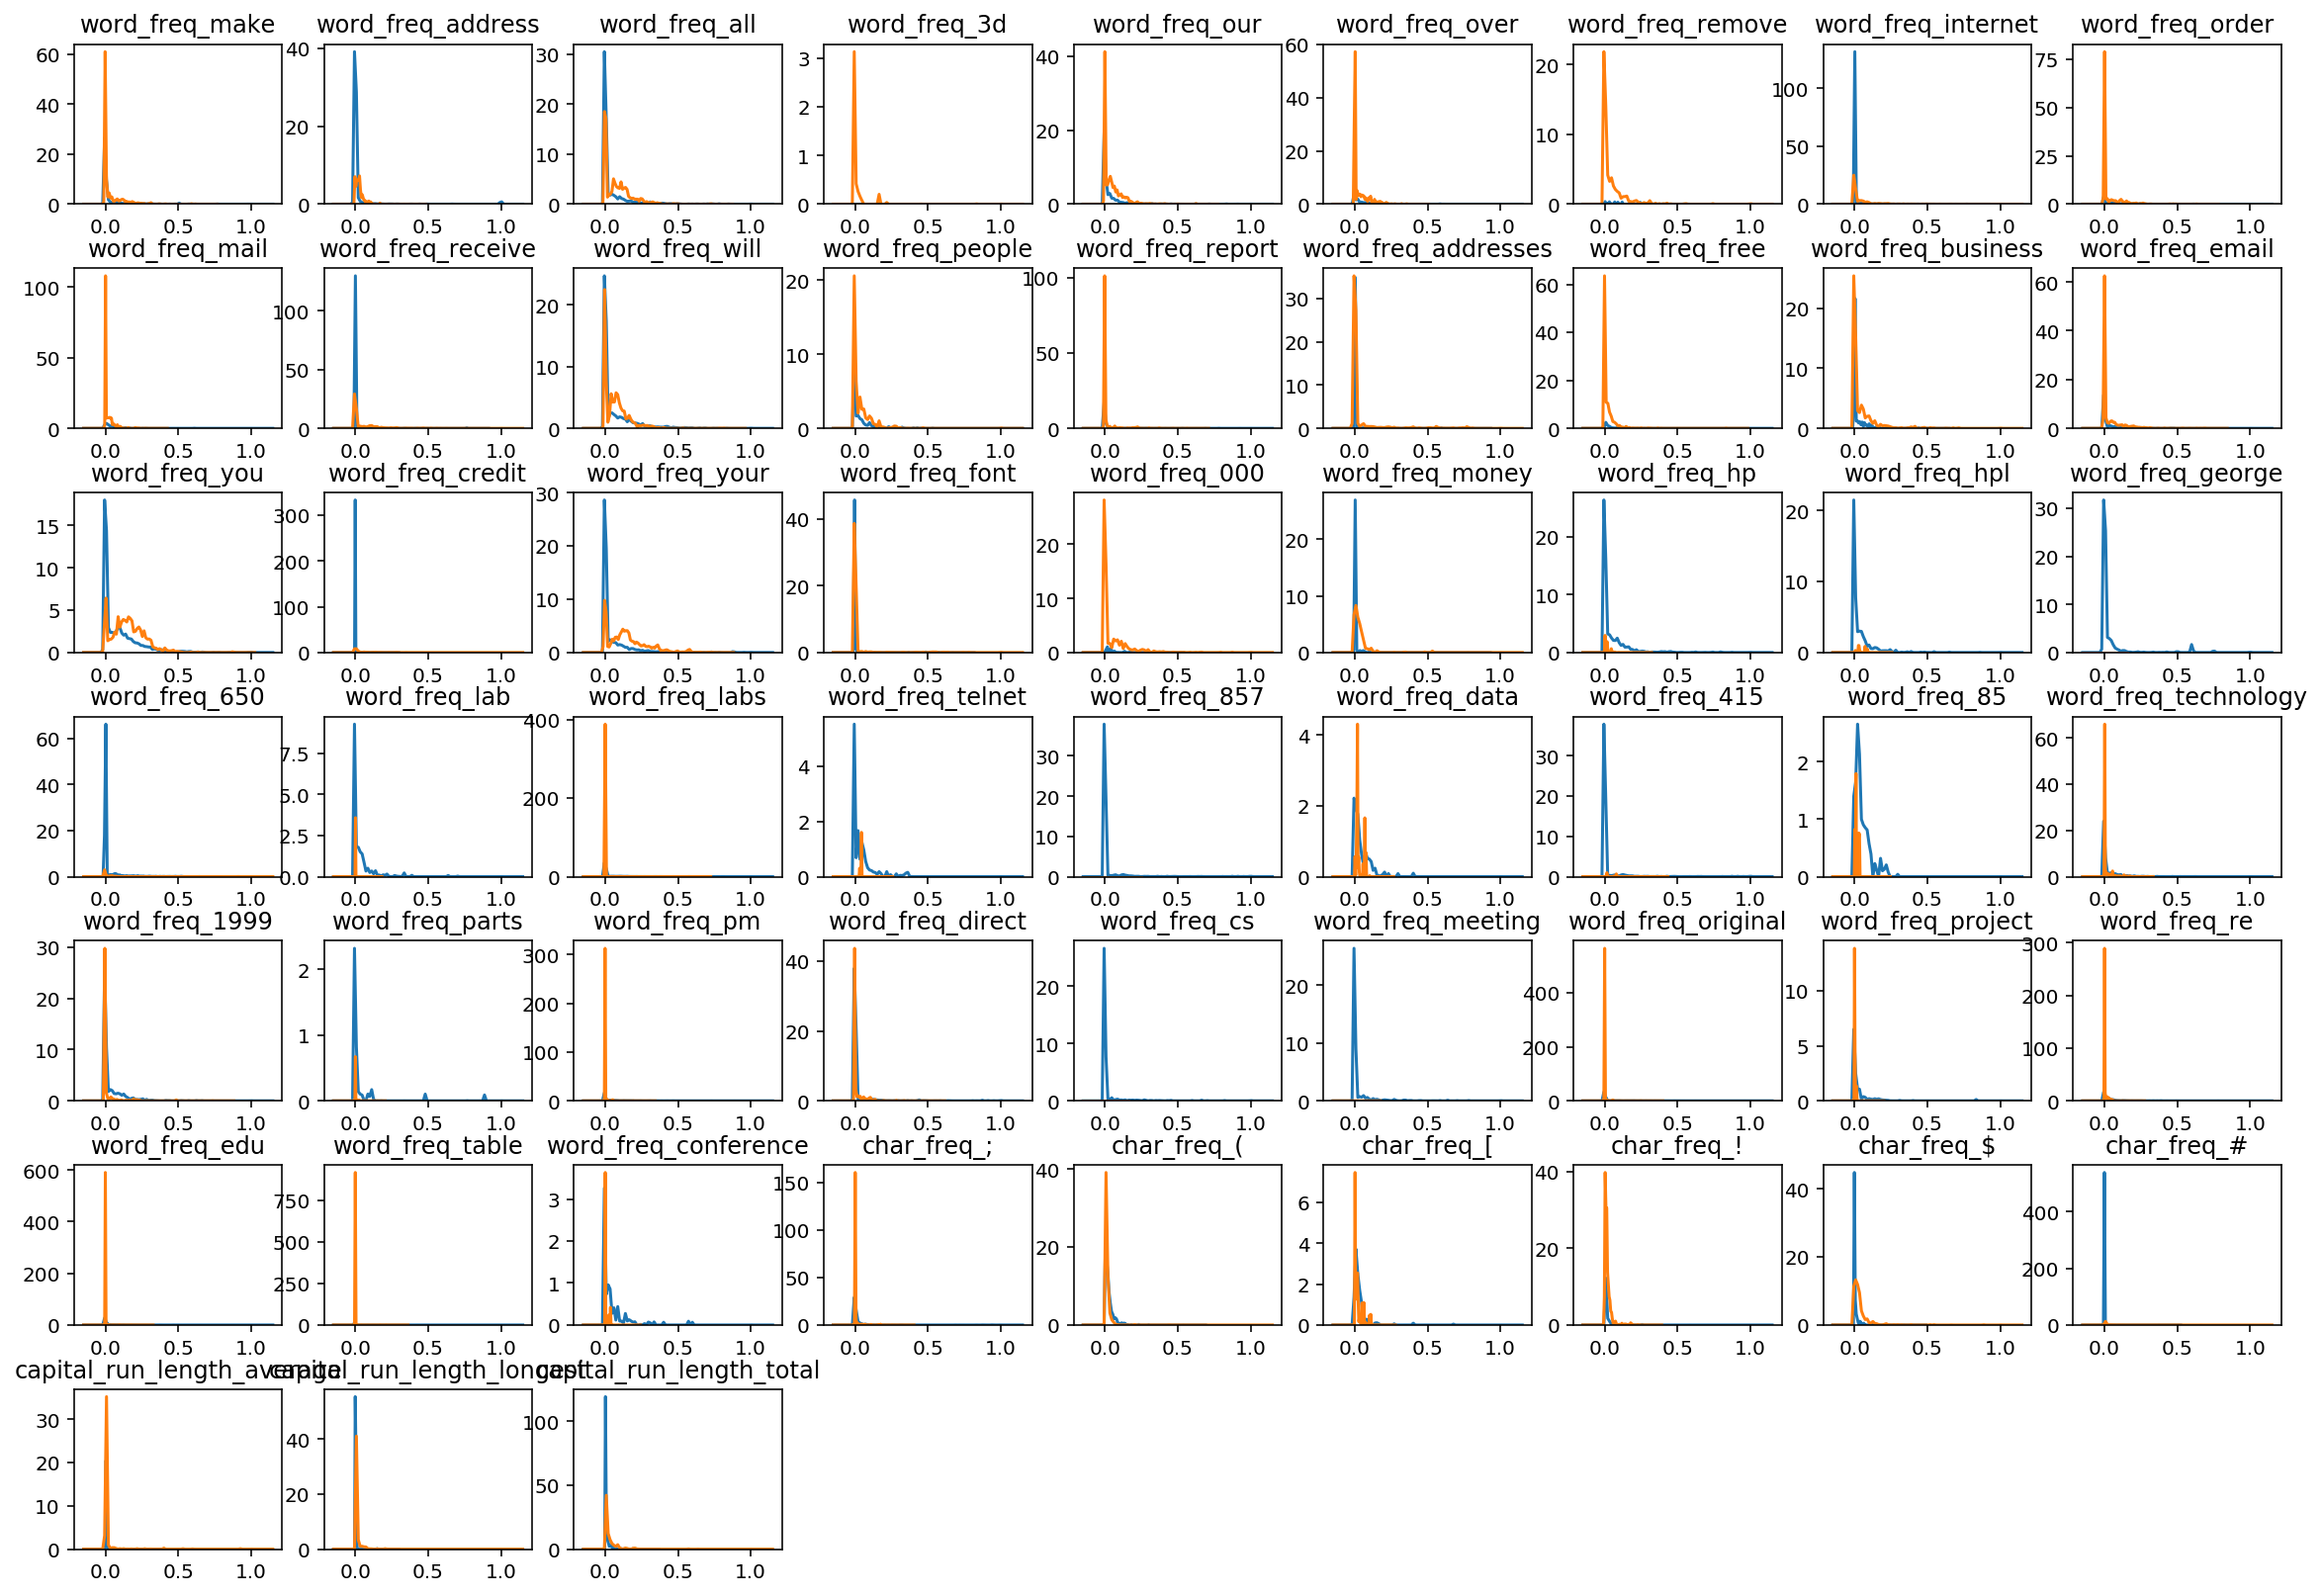

In [7]:
## 使用训练数据集对数据特征进行可视化
## 使用密度曲线对比不同类别在每个特征上的数据分布情况
colname = spam.columns.values[:-1]
plt.figure(figsize=(20,14))
for ii in range(len(colname)):
    plt.subplot(7,9,ii+1)
    sns.kdeplot(X_train_s[y_train == 0,ii], bw=0.05)
    sns.kdeplot(X_train_s[y_train == 1,ii], bw=0.05)
    plt.title(colname[ii])
plt.subplots_adjust(hspace=0.4)
plt.show()

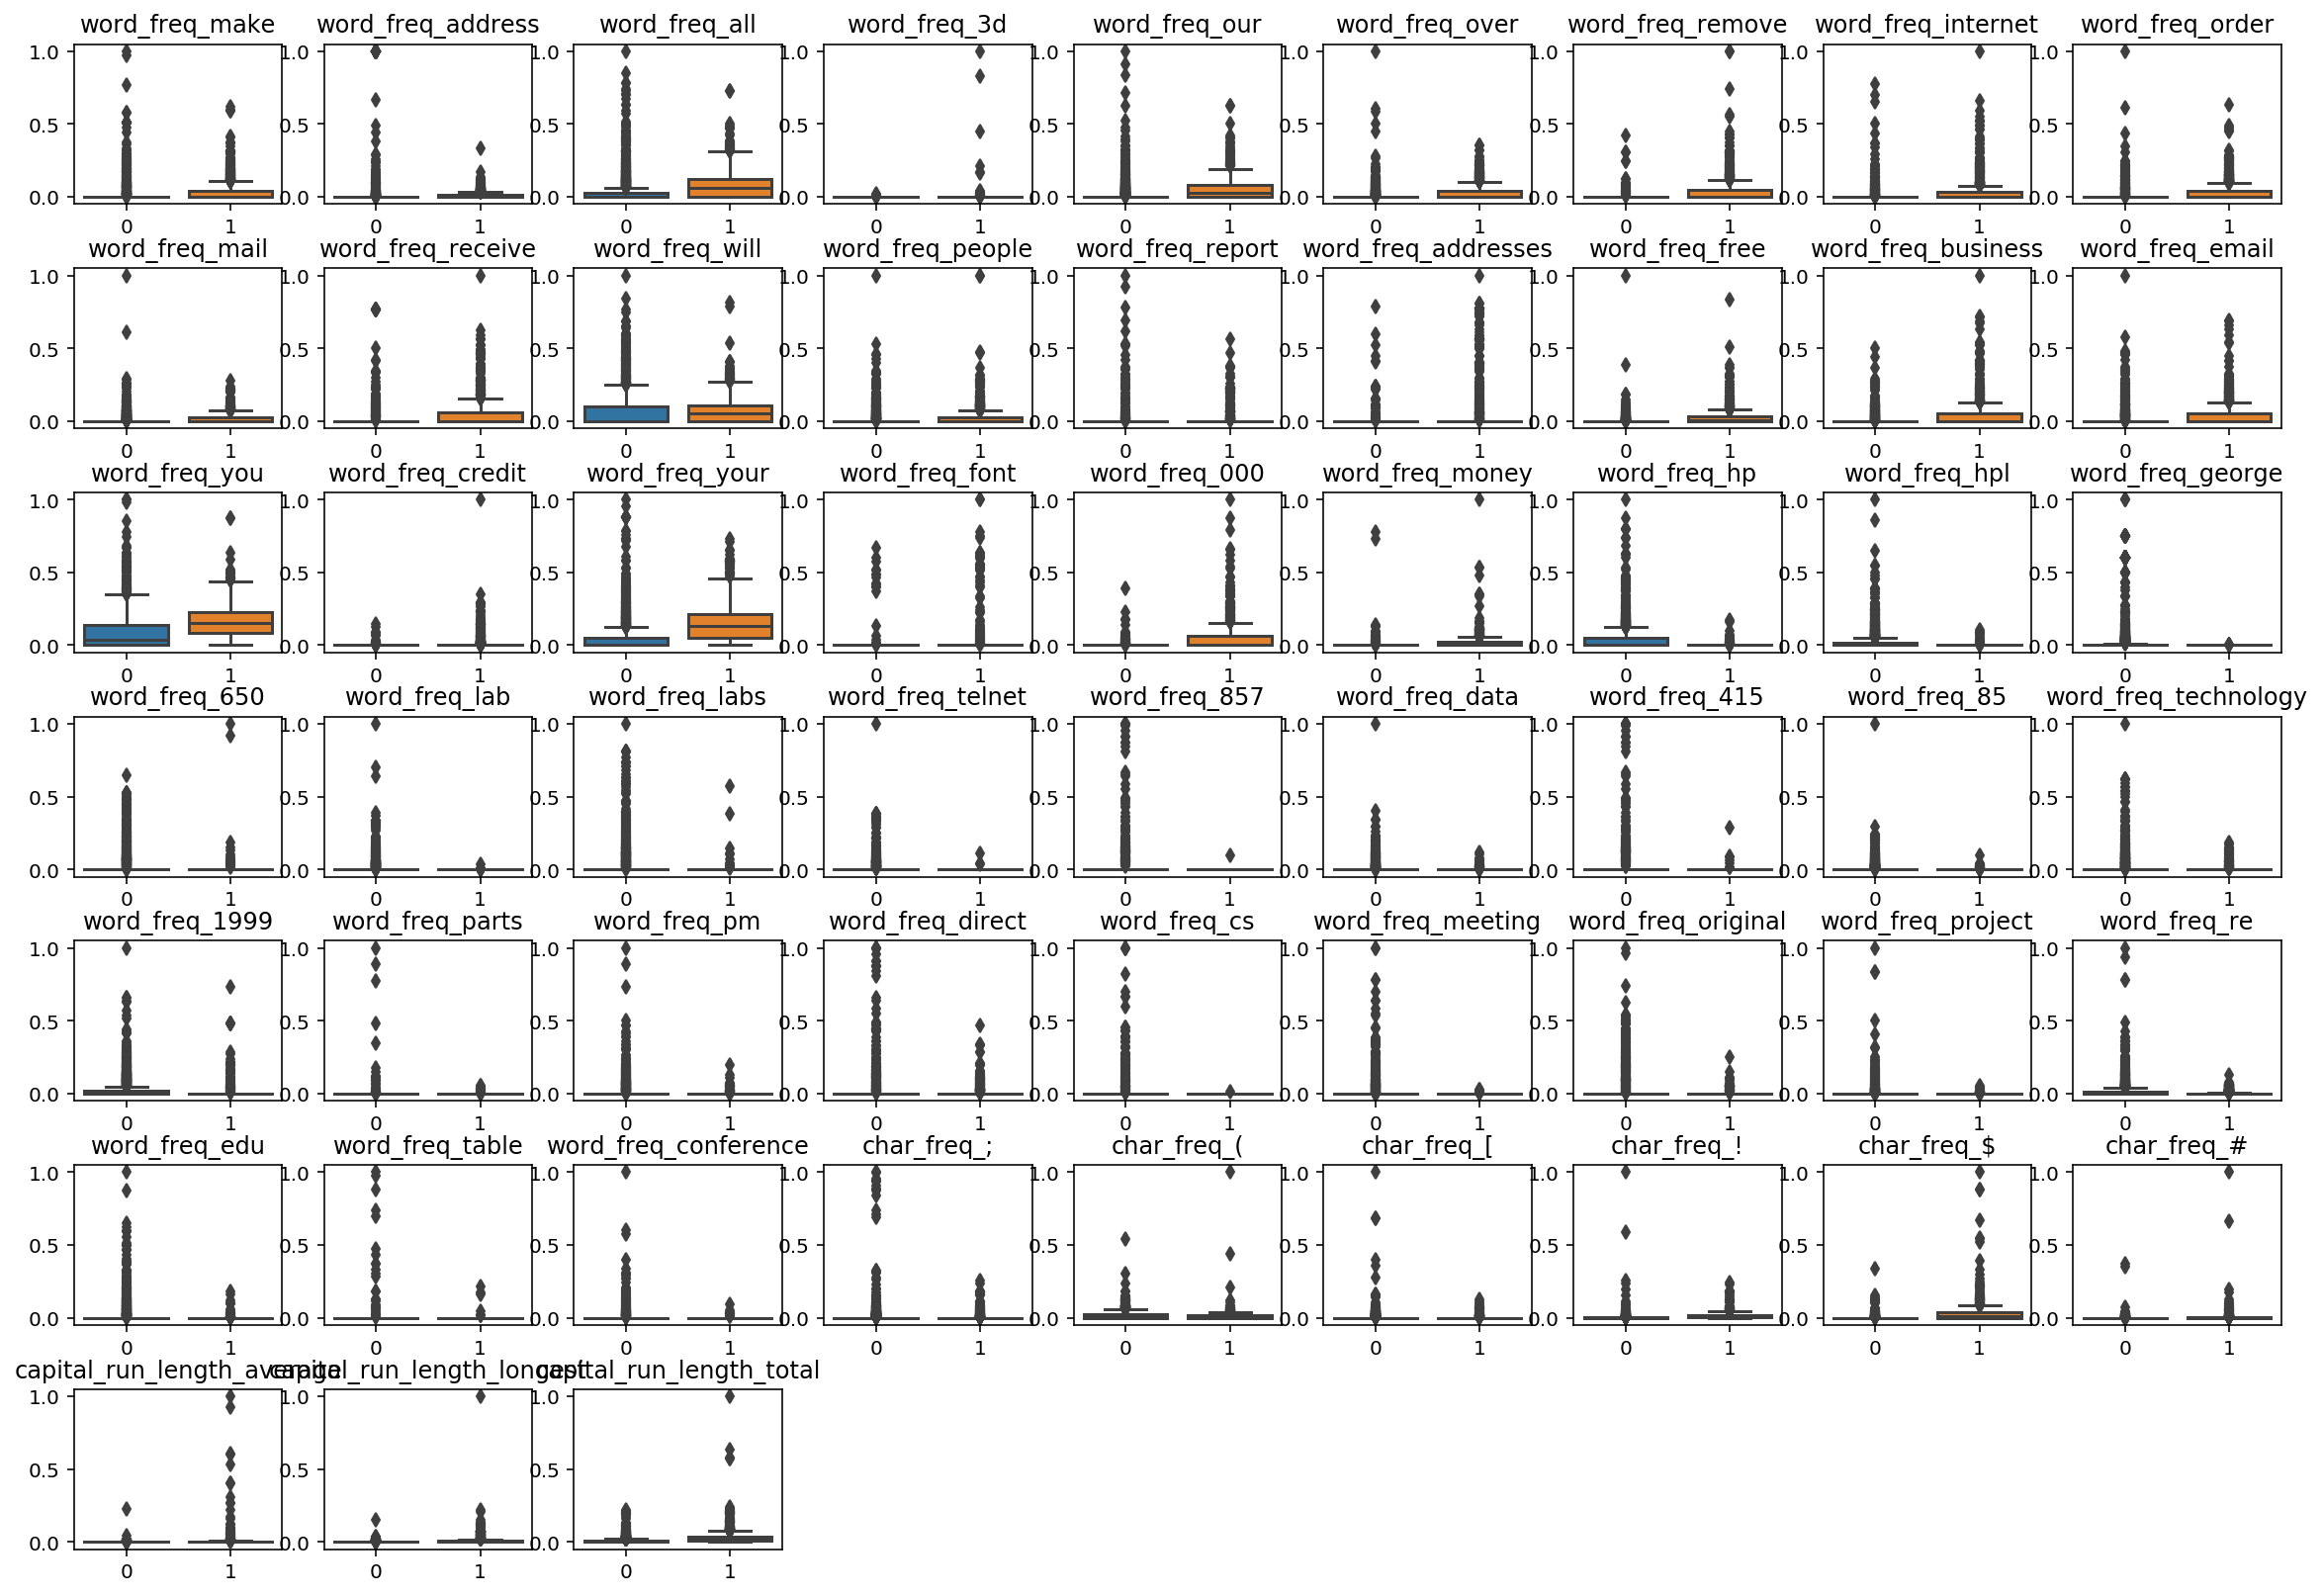

In [7]:
## 使用训练数据集对数据特征进行可视化
## 使用箱线对比不同类别在每个特征上的数据分布情况
colname = spam.columns.values[:-1]
plt.figure(figsize=(20,14))
for ii in range(len(colname)):
    plt.subplot(7,9,ii+1)
    sns.boxplot(x = y_train,y = X_train_s[:,ii])
    plt.title(colname[ii])
plt.subplots_adjust(hspace=0.4)
plt.show()

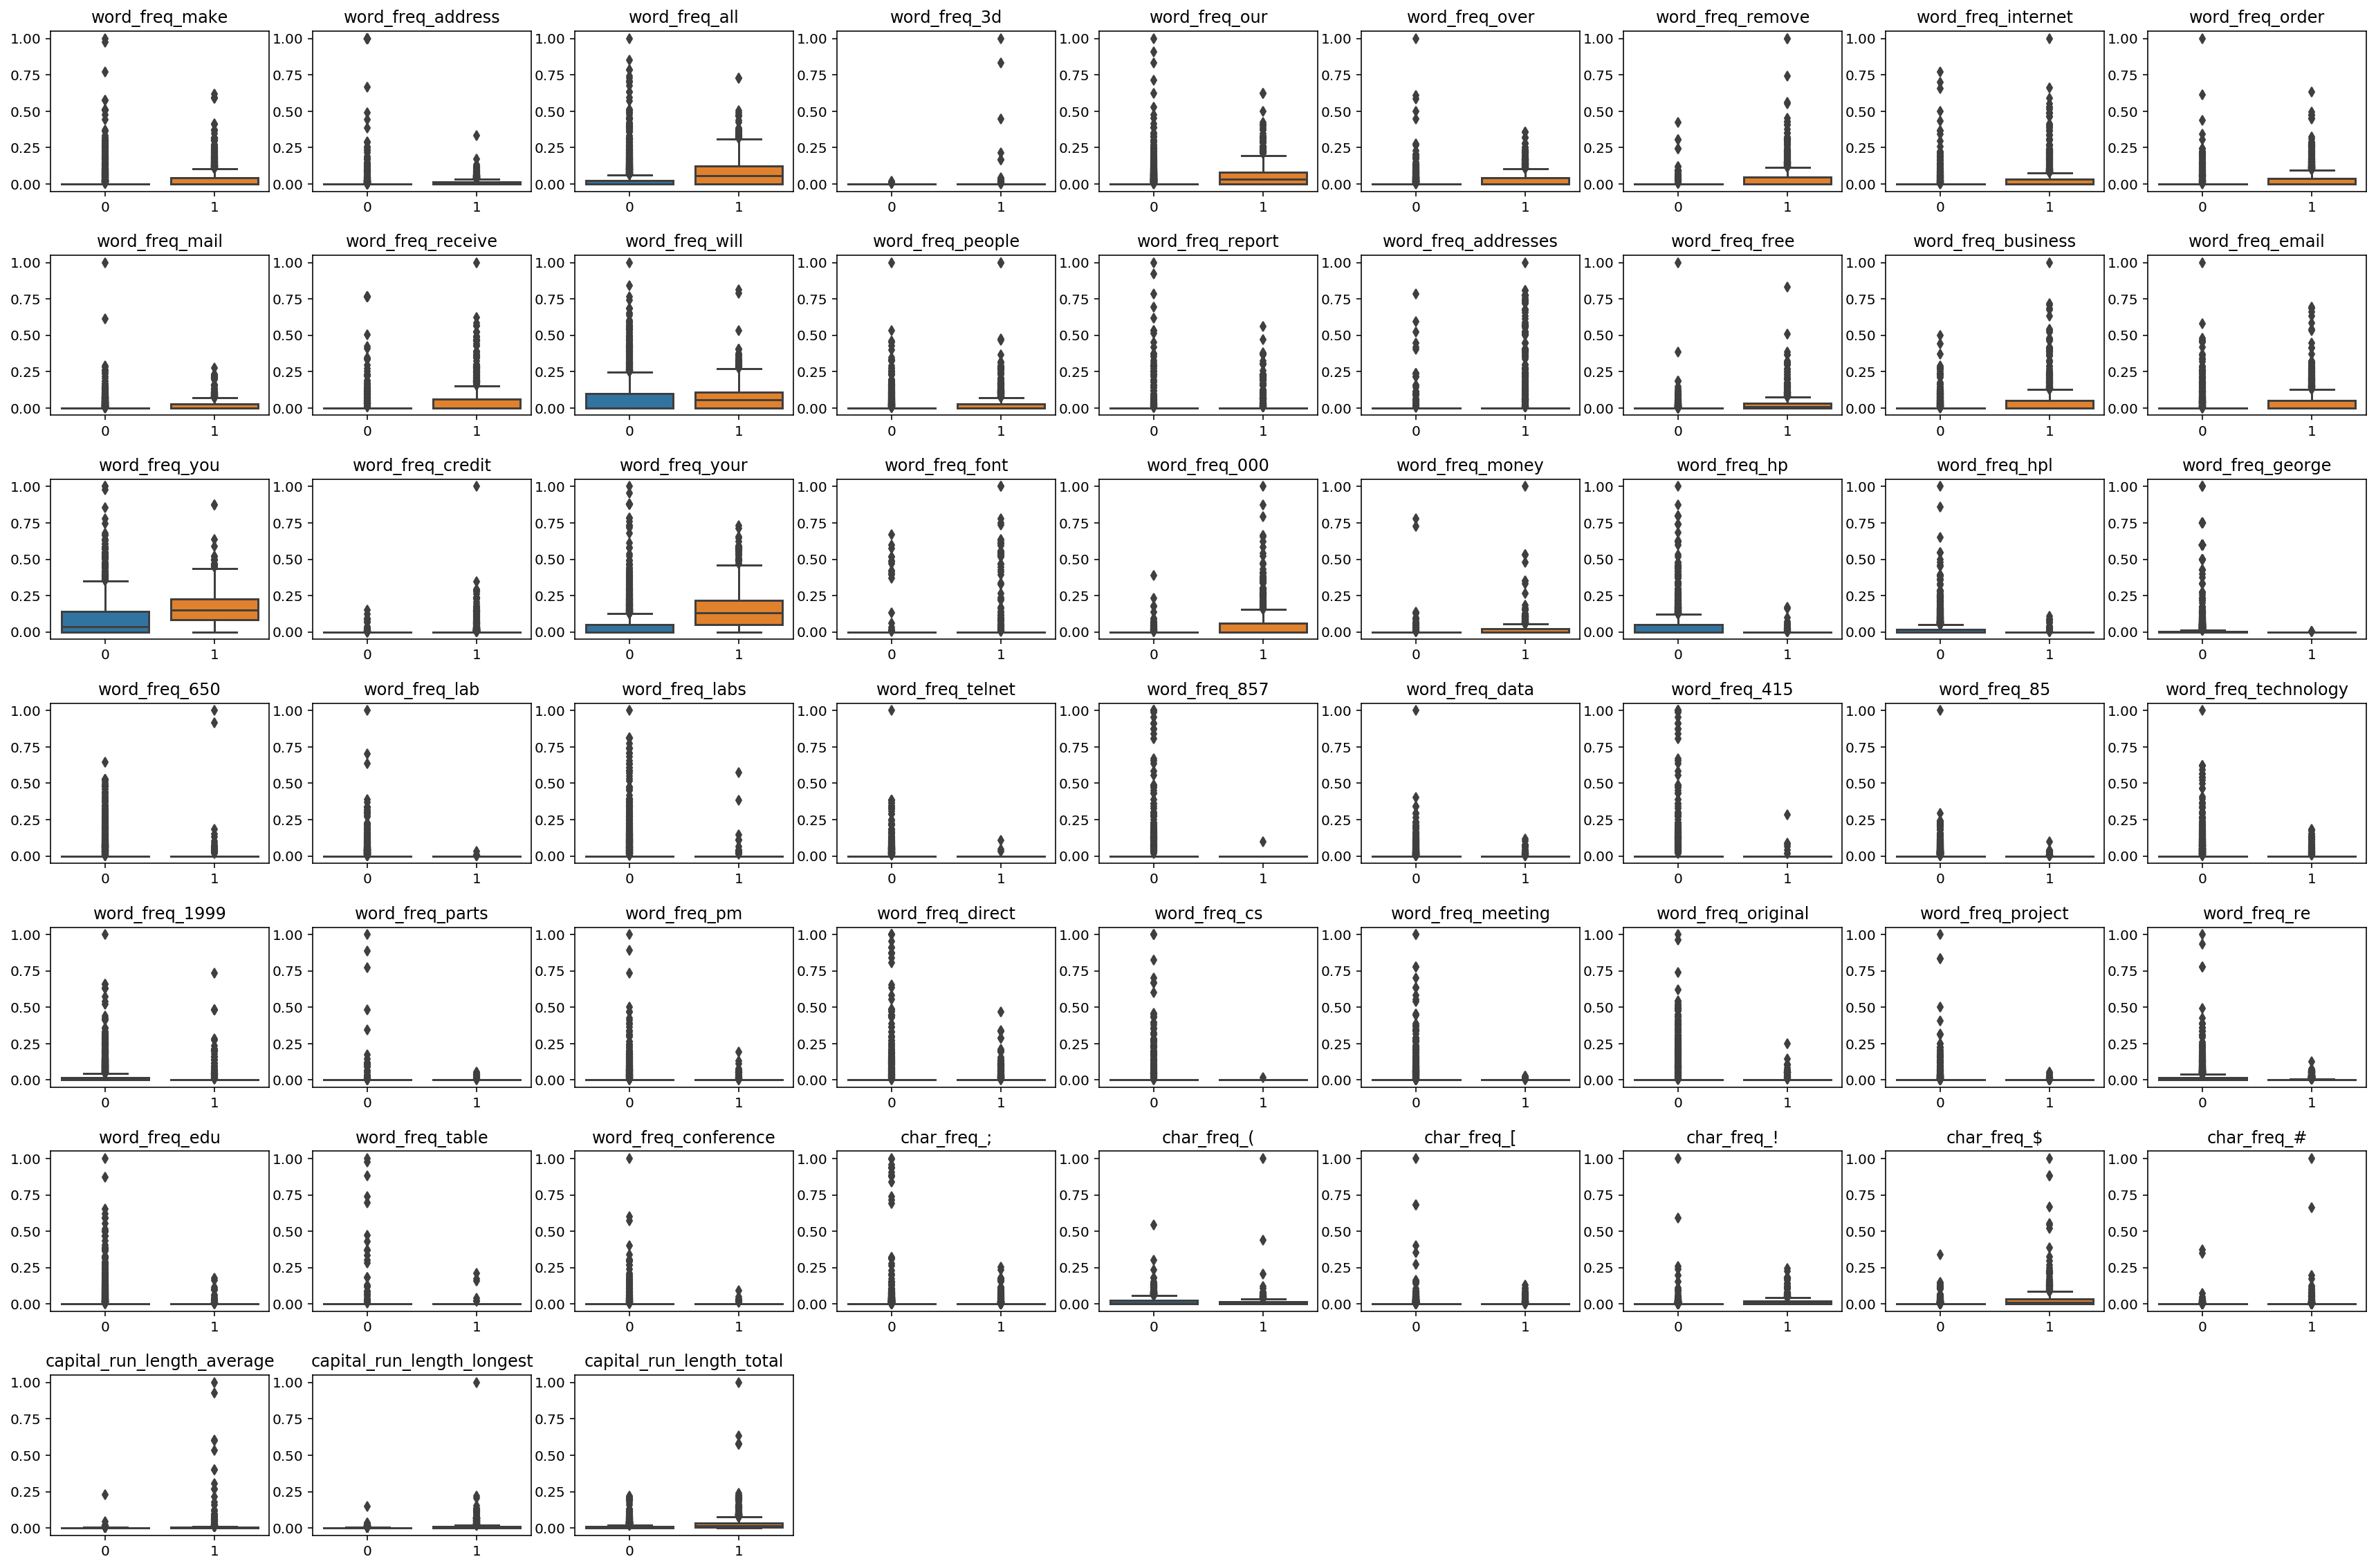

In [8]:
## 使用训练数据集对数据特征进行可视化
## 使用箱线对比不同类别在每个特征上的数据分布情况
colname = spam.columns.values[:-1]
plt.figure(figsize=(30,20))
for ii in range(len(colname)):
    plt.subplot(7,9,ii+1)
    sns.boxplot(x = y_train,y = X_train_s[:,ii])
    plt.title(colname[ii])
plt.subplots_adjust(hspace=0.4)
plt.show()

In [8]:
## 将数据转化为张量
X_train_t = torch.from_numpy(X_train_s.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
X_test_t = torch.from_numpy(X_test_s.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))
## 将训练集转化为张量后,使用TensorDataset将X和Y整理到一起
train_data = Data.TensorDataset(X_train_t,y_train_t)
## 定义一个数据加载器，将训练数据集进行批量处理
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 1, # 使用两个进程 
)

In [9]:
len(train_loader)

54

### 搭建一个全连接神经网络

In [10]:
## 全连接网络
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica,self).__init__()
        ## 定义第一个隐藏层
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features = 57, ## 第一个隐藏层的输入，数据的特征数
                out_features = 30,## 第一个隐藏层的输出，神经元的数量
                bias=True, ## 默认会有偏置
            ),
            nn.ReLU()
        )
        ## 定义第二个隐藏层
        self.hidden2 = nn.Sequential(
            nn.Linear(30,10),
            nn.ReLU()
        )
        ## 分类层
        self.classifica = nn.Sequential(
            nn.Linear(10,2),
            nn.Sigmoid()
        )

    ## 定义网络的向前传播路径   
    def forward(self, x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classifica(fc2)
        ## 输出为两个隐藏层和输出层的输出
        return fc1,fc2,output
        
## 输出我们的网络结构
mlpc = MLPclassifica()
print(mlpc)

MLPclassifica(
  (hidden1): Sequential(
    (0): Linear(in_features=57, out_features=30, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
  )
  (classifica): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


### 可视化网络的结果

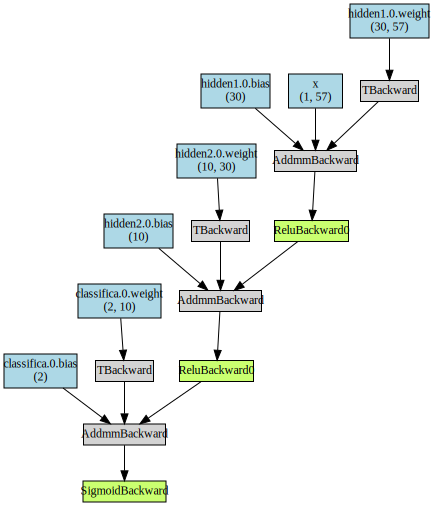

In [11]:
## 使用make_dot可视化网络
x = torch.randn(1,57).requires_grad_(True)
y = mlpc(x)
Mymlpcvis = make_dot(y, params=dict(list(mlpc.named_parameters()) + [('x', x)]))
Mymlpcvis

In [12]:
## 将mlpvis保存为图片
# Mymlpcvis.format = "png" ## 形式转化为png,默认pdf
# ## 指定文件保存位置
# Mymlpcvis.directory = "data/chap5/Mymlpc_vis"
# Mymlpcvis.view() ## 会自动在当前文件夹生成文件

### 使用未预处理的数据训练模型

In [13]:
## 将数据转化为张量
X_train_nots = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
X_test_nots = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))
## 将训练集转化为张量后,使用TensorDataset将X和Y整理到一起
train_data_nots = Data.TensorDataset(X_train_nots,y_train_t)
## 定义一个数据加载器，将训练数据集进行批量处理
train_nots_loader = Data.DataLoader(
    dataset = train_data_nots, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 1, # 使用1个进程 
)

In [14]:
## 输出我们的网络结构
mlpc = MLPclassifica()
print(mlpc)

MLPclassifica(
  (hidden1): Sequential(
    (0): Linear(in_features=57, out_features=30, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
  )
  (classifica): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


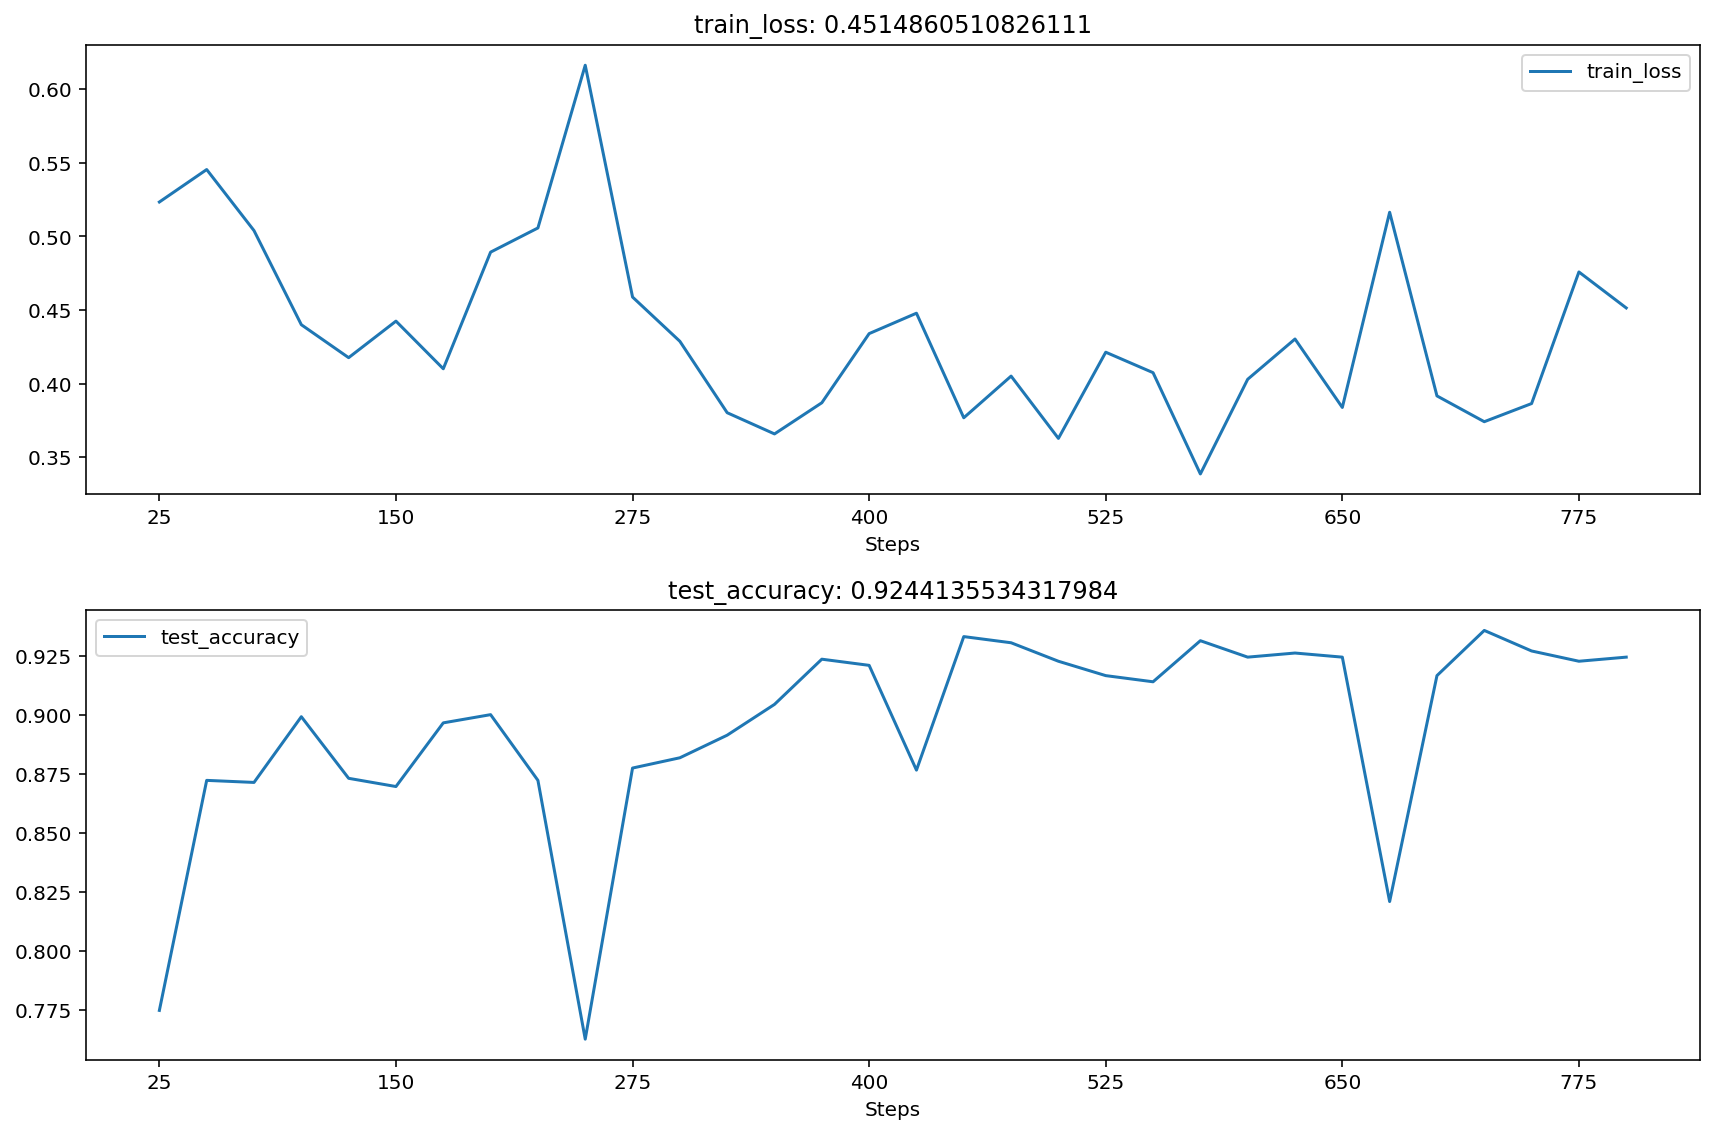

In [15]:
# 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(),lr=0.01)  
loss_func = nn.CrossEntropyLoss()   # 二分类损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(15):
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_nots_loader):  
        ## 计算每个batch的
        _,_,output = mlpc(b_x)               # MLP在训练batch上的输出
        train_loss = loss_func(output, b_y)   # 二分类交叉熵损失函数
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        train_loss.backward()           # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        niter = epoch*len(train_loader)+step+1
        
    ## 计算每经过print_step次迭代后的输出
        if niter % print_step == 0:
            _,_,output = mlpc(X_test_nots)
            _,pre_lab = torch.max(output,1)
            test_accuracy = accuracy_score(y_test_t,pre_lab)
            # 为history添加epoch，损失和精度
            history1.log(niter, train_loss=train_loss, 
                         test_accuracy=test_accuracy)
            # 使用两个图像可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])

            

可以发现，损失函数很难迭代稳定

### 使用hiddenlayer包可视化网络训练过程

可视化网络训练过程，您需要使用两个类：history记录存储指标，而Canvas来绘制它们

In [16]:
## 输出我们的网络结构
mlpc = MLPclassifica()
print(mlpc)

MLPclassifica(
  (hidden1): Sequential(
    (0): Linear(in_features=57, out_features=30, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
  )
  (classifica): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


### 使用预处理后的数据的网络训练过程

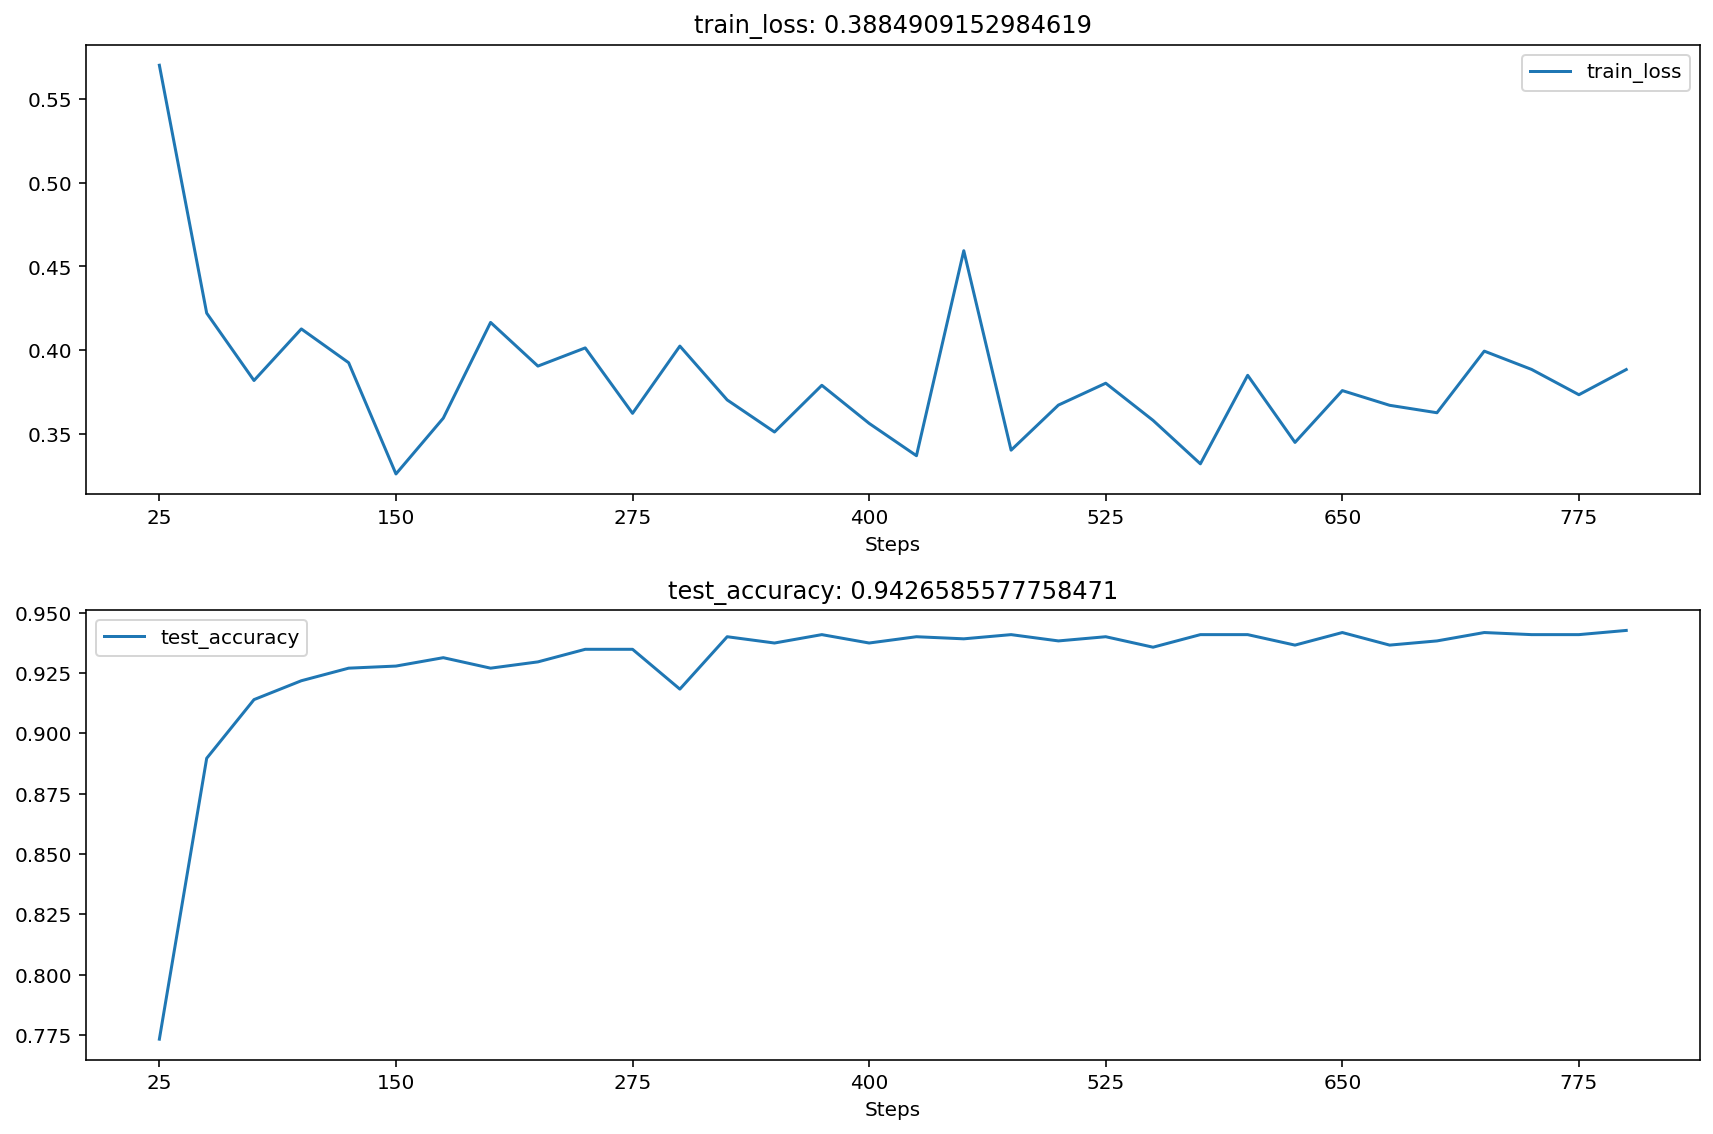

In [17]:
# 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(),lr=0.01)  
loss_func = nn.CrossEntropyLoss()   # 二分类损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(15):
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):  
        ## 计算每个batch的
        _,_,output = mlpc(b_x)               # MLP在训练batch上的输出
        train_loss = loss_func(output, b_y)   # 二分类交叉熵损失函数
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        train_loss.backward()           # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        niter = epoch*len(train_loader)+step+1
        
    ## 计算每经过print_step次迭代后的输出
        if niter % print_step == 0:
            _,_,output = mlpc(X_test_t)
            _,pre_lab = torch.max(output,1)
            test_accuracy = accuracy_score(y_test_t,pre_lab)
            # 为history添加epoch，损失和精度
            history1.log(niter, train_loss=train_loss, 
                         test_accuracy=test_accuracy)
            # 使用两个图像可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])

            

In [18]:
## 计算最终模型在测试集上的精度
_,_,output = mlpc(X_test_t)
_,pre_lab = torch.max(output,1)
test_accuracy = accuracy_score(y_test_t,pre_lab)
print("test_accuracy:",test_accuracy)
print(classification_report(y_test_t,pre_lab))
print(confusion_matrix(y_test_t,pre_lab))


test_accuracy: 0.9339704604691572
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       686
           1       0.94      0.89      0.92       465

    accuracy                           0.93      1151
   macro avg       0.93      0.93      0.93      1151
weighted avg       0.93      0.93      0.93      1151

[[659  27]
 [ 49 416]]


### 损失使用平均值的输出

In [19]:
mlpc = MLPclassifica()
print(mlpc)

MLPclassifica(
  (hidden1): Sequential(
    (0): Linear(in_features=57, out_features=30, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
  )
  (classifica): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


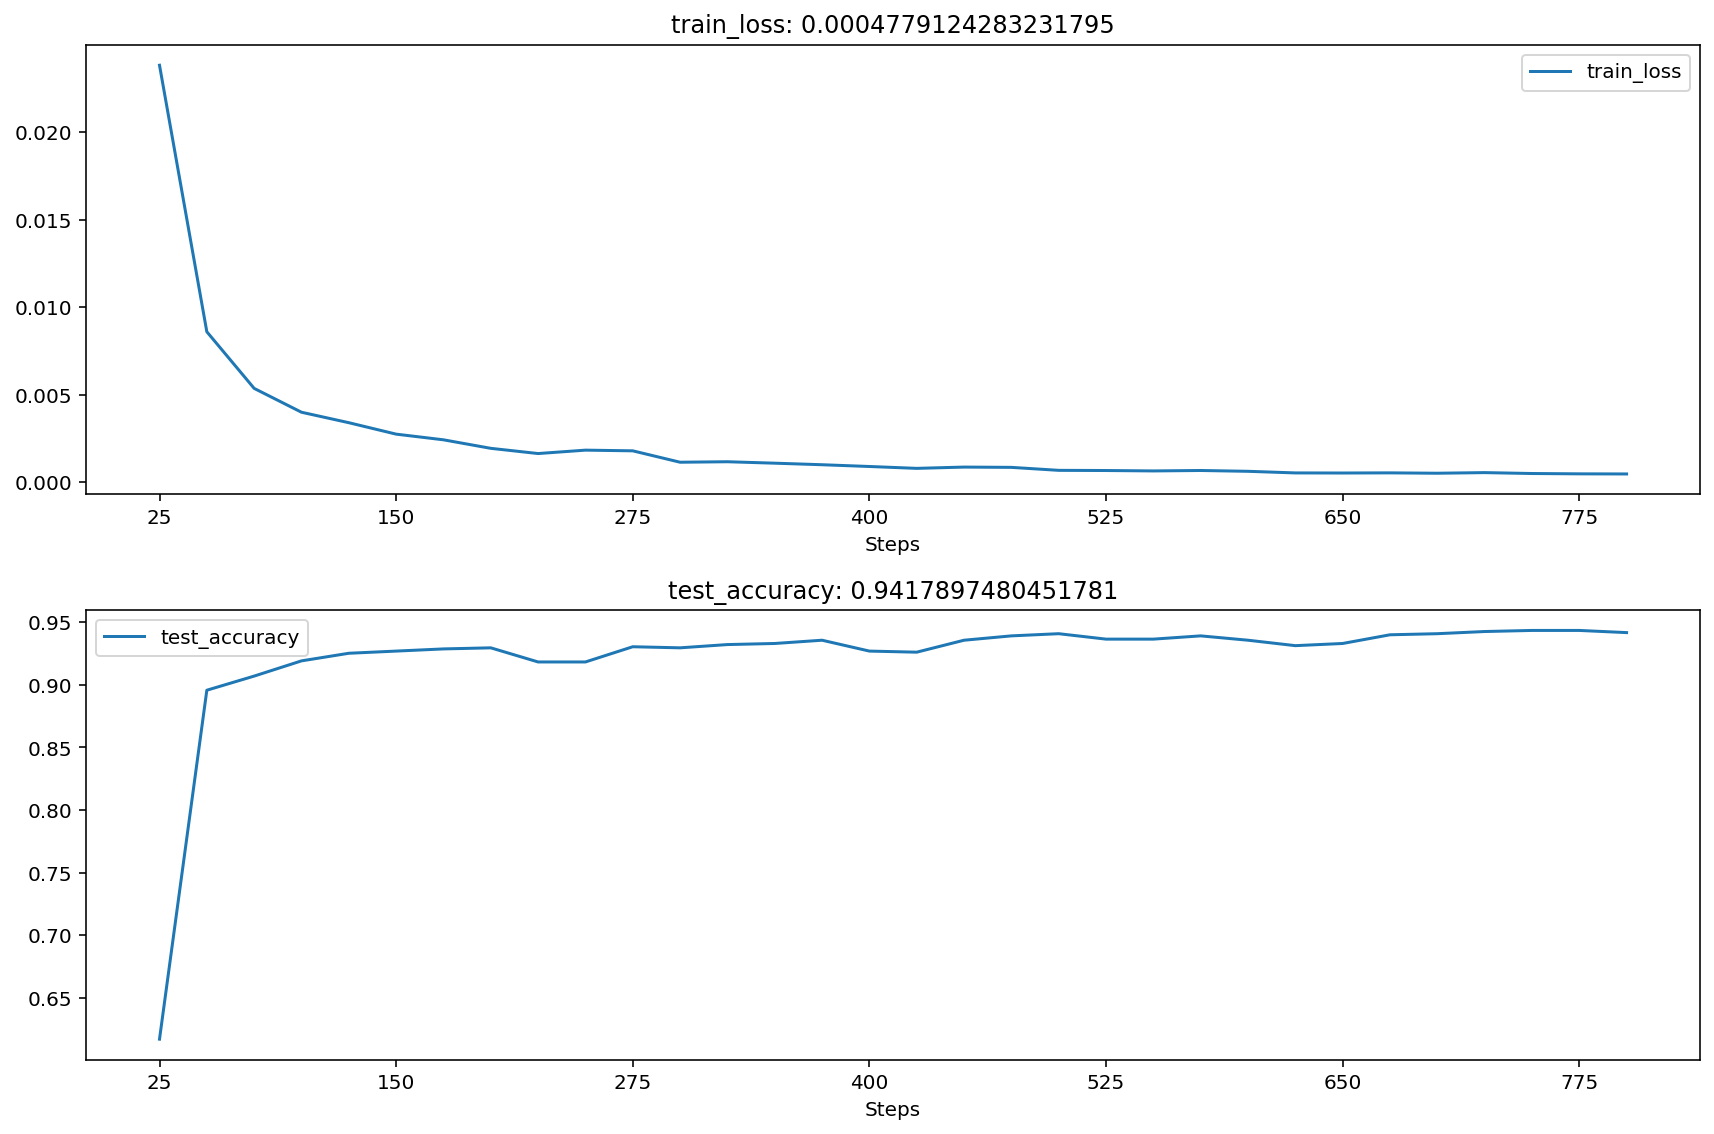

In [20]:
# 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(),lr=0.01)  
loss_func = nn.CrossEntropyLoss()   # 二分类损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
print_step = 25
train_loss_all = 0
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(15):
    ## 对训练数据的迭代器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):  
        ## 计算每个batch的
        _,_,output = mlpc(b_x)               # MLP在训练batch上的输出
        train_loss = loss_func(output, b_y)   # 二分类交叉熵损失函数
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        train_loss.backward()           # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        niter = epoch*len(train_loader)+step+1
        train_loss_all += train_loss
        
    ## 计算每经过print_step次迭代后的输出
        if niter % print_step == 0:
            _,_,output = mlpc(X_test_t)
            _,pre_lab = torch.max(output,1)
            test_accuracy = accuracy_score(y_test_t,pre_lab)
            # 为history添加epoch，损失和精度
            history1.log(niter, train_loss=train_loss / niter, 
                         test_accuracy=test_accuracy)
            # 使用两个图像可视化损失函数和精度
            with canvas1:
                canvas1.draw_plot(history1["train_loss"])
                canvas1.draw_plot(history1["test_accuracy"])

            

In [21]:
## 计算最终模型在测试集上的精度
_,_,output = mlpc(X_test_t)
_,pre_lab = torch.max(output,1)
test_accuracy = accuracy_score(y_test_t,pre_lab)
print("test_accuracy:",test_accuracy)
print(classification_report(y_test_t,pre_lab))
print(confusion_matrix(y_test_t,pre_lab))


test_accuracy: 0.9400521285838401
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       686
           1       0.94      0.91      0.92       465

    accuracy                           0.94      1151
   macro avg       0.94      0.93      0.94      1151
weighted avg       0.94      0.94      0.94      1151

[[661  25]
 [ 44 421]]


In [22]:
## 计算最终模型在测试集上的精度
mlpc.eval()
_,_,output = mlpc(X_test_t)
pre_lab = torch.argmax(output,1)
test_accuracy = accuracy_score(y_test_t,pre_lab)
print("test_accuracy:",test_accuracy)
print(classification_report(y_test_t,pre_lab))
print(confusion_matrix(y_test_t,pre_lab))


test_accuracy: 0.9400521285838401
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       686
           1       0.94      0.91      0.92       465

    accuracy                           0.94      1151
   macro avg       0.94      0.93      0.94      1151
weighted avg       0.94      0.94      0.94      1151

[[661  25]
 [ 44 421]]


In [23]:
torch.argmax(output,1)


tensor([0, 1, 0,  ..., 0, 1, 1])

### 获取中间层的输出，并可视化

1:使用中间层的输出

2:使用钩子获取中间层的输出

In [24]:
mlpc = MLPclassifica()
print(mlpc)

MLPclassifica(
  (hidden1): Sequential(
    (0): Linear(in_features=57, out_features=30, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): ReLU()
  )
  (classifica): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


In [25]:
## 计算最终模型在测试集上的第二个隐藏层的输出
_,test_fc2,_ = mlpc(X_test_t)
print("test_fc2.shape:",test_fc2.shape)
## 使用散点图进行可视化
## 对输出进行降维并可视化
test_fc2_tsne = TSNE(n_components=2).fit_transform(test_fc2.data.numpy())

test_fc2.shape: torch.Size([1151, 10])


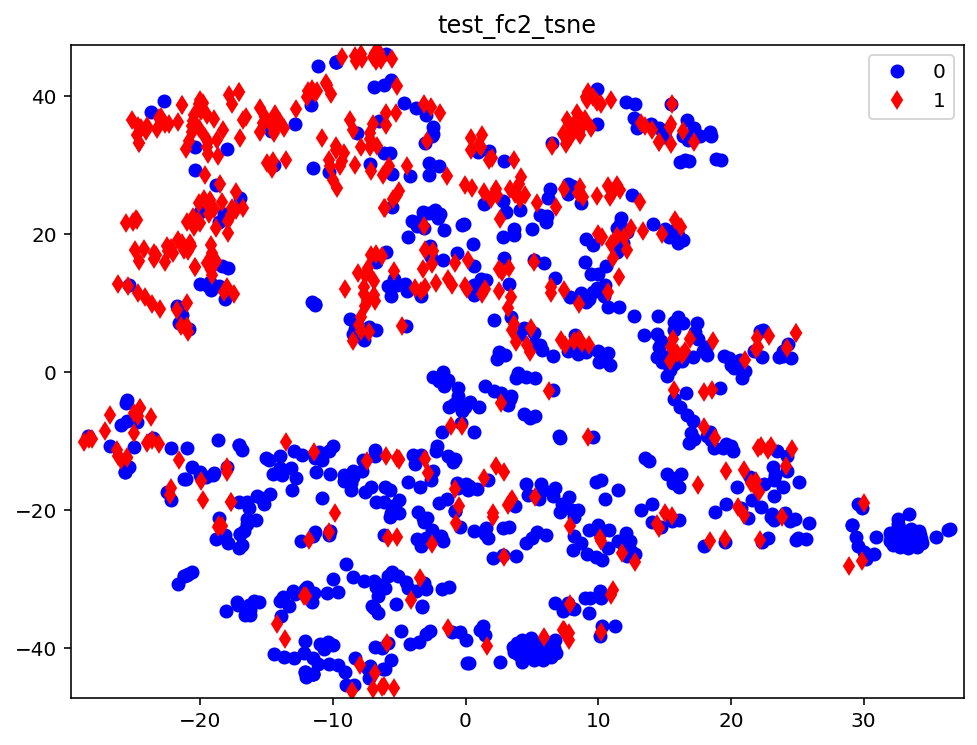

In [26]:
## 将特征进行可视化
plt.figure(figsize=(8,6))
# 可视化前设置坐标系的取值范围
plt.xlim([min(test_fc2_tsne[:,0]-1),max(test_fc2_tsne[:,0])+1])
plt.ylim([min(test_fc2_tsne[:,1]-1),max(test_fc2_tsne[:,1])+1])
plt.plot(test_fc2_tsne[y_test==0,0],test_fc2_tsne[y_test==0,1],
         "bo",label = "0")
plt.plot(test_fc2_tsne[y_test==1,0],test_fc2_tsne[y_test==1,1],
         "rd",label = "1")
plt.legend()
plt.title("test_fc2_tsne")
plt.show()

In [27]:
## 使用钩子获取分类层的2个特征
## 定义一个辅助函数，来获取指定层名称的特征
activation = {} ## 保存不同层的输出
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [28]:
## 全连接网络获取第一个全连接层的输出
mlpc.classifica.register_forward_hook(get_activation("classifica"))
_,_,_ = mlpc(X_test_t)
classifica = activation["classifica"].data.numpy()
print("classifica.shape:",classifica.shape)

classifica.shape: (1151, 2)


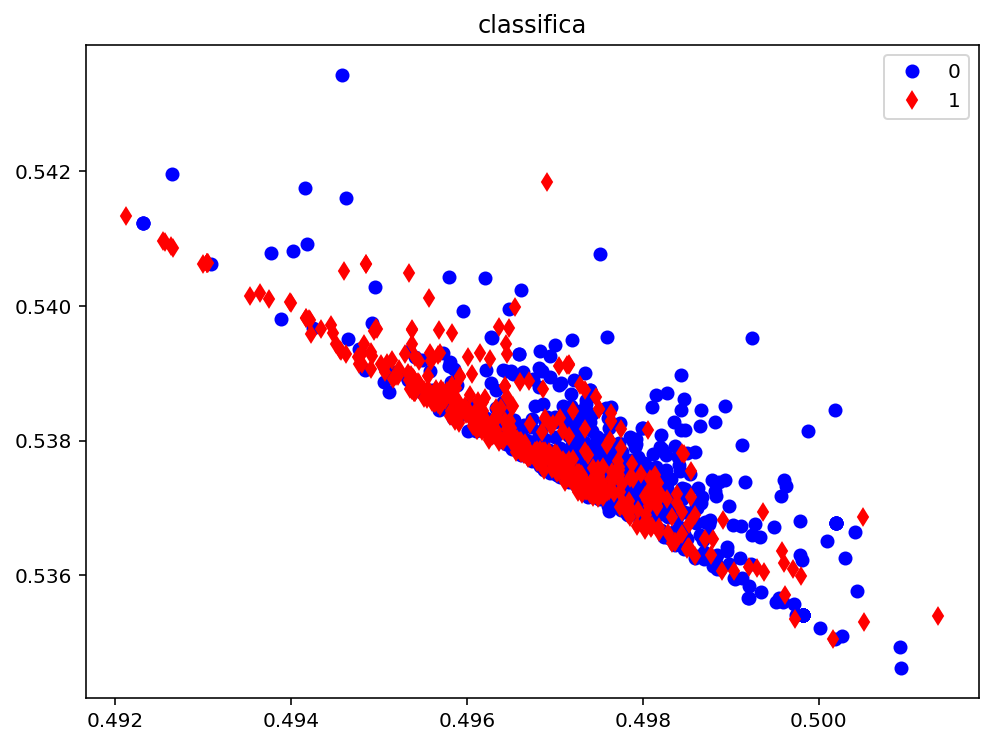

In [29]:
## 将特征进行可视化
plt.figure(figsize=(8,6))
# 可视化前设置坐标系的取值范围
plt.plot(classifica[y_test==0,0],classifica[y_test==0,1],
         "bo",label = "0")
plt.plot(classifica[y_test==1,0],classifica[y_test==1,1],
         "rd",label = "1")
plt.legend()
plt.title("classifica")
plt.show()